1 Prepração do notebook
2 Obtenção dos dados, tratamento e geração de Data Frames

* Dados sobre Covid
    * Obtenção de dados do COVID19 e geração do Data Frame df_covid19_br
    * Geração do df_covid19_br_para_shapefile com tratamento dos dados
    * Geração do Geo Data Frames gdf_covid19_br, com os casos para o Brasil, e gdf_covid19_pr, com os casos do Paraná
* Obtenção dos Demais dados
* nível de hierarquia urbana
* população
* mobilidade pendular
* níveis de exportação
* pib percapita
* número de pessoas com renda elevada (a definir o critério)
* tentar identificar uma forma de criar uma base que se atualize dinamicamente e identifique avizinhamento de municípios 0 e 1 

3 Análise Exploratória Correlações

* Gerar painel de estatística descritiva

* Gerar gráficos de distribuição
* Fazer matriz de correlações

4 Modelização

# Obtenção, tratamento e Análise Exploratória dos dados sobre COVID-19 no Brasil

# Preparação do Notebook

* Importação das principais bibliotecas
* Configuração das operações por default (estilos e tamanhos de gráficos)

In [1]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
# configurações

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos

# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn

## Importação e Tratamento Preliminar dos Dados

* Verificação da Estrutura dos dados
* Observação da pertinência dos tipos
* Identificação e tratamento dos dados nulos
* Codificação de variáveis categóricas
* Separação dos batches
    * Estratificado
    * Não Estratificado
* Criar versão com regularização de escala

### Função de Importação de Base de Dados e Geração do Data Frame df-covid19_br
* Abaixo se encontra uma função colect_cases, que obtem os dados sobre COVID-19 compilados dos boletins e disponível em "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
    * Os dados são salvos em Pandas Data Frame
    * Os nomes das colunas são corrigidos
    * As duplicidades são eliminadas, pela retirada de várias linhas com totais

Observações: É conveniente que, no futuro, a função tenha um tratamento para que as datas não estejam em formato texto

In [2]:
def colect_cases(output=None, output_format='csv',correct_columns=True, correct_rows=True):
    #Retrieves the notified cases in Brazilian boletins found in 
    #https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv
    # correct_columns -> whether or not to rearrange the columns and rename them
    # Correct_rows -> whether or not to remove the total cases by date, which would duplicate the values per day
    # name_csv -> string withe name of the csv file to save the content of the Data Frame. If name_csv equals to None, no file is saved
    
    
    # loads the CSV data into df_cases
    df_cases = pd.read_csv(
        'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv', 
        parse_dates=True,
        infer_datetime_format=True)

    
    # if correct_columns == True, it rearranges the columns orders and renames them    
    if correct_columns == True:
        df_cases = df_cases[['ibgeID', 'city', 'state', 'date', 'newCases', 'totalCases']].rename(columns={'ibgeID':'cod_mun', 'city':'municipio', 'state':'estado', 'date':'data', 'newCases':'novos_casos', 'totalCases':'casos_total'})    
    
    # if correct_rows == True, it removes the rows that show the total cases by date, which would duplicate the values per day    
    if correct_rows == True:
        filter_cases_total = df_cases.loc[df_cases.estado == 'TOTAL']
        df_cases.drop(filter_cases_total.index, axis=0, inplace=True)

    # removes the state name in the municipality column
    df_cases.municipio = df_cases.municipio.apply(lambda a_corrigir: a_corrigir.split('/')[0]) 
        
    # if name_csv contains the name of a csv file, a file will be created in the current directory 
    #or in the specified directory 
    if output != None:
        if output_format == 'csv':
            df_cases.to_csv(output, encoding='utf-16')
        if output_format == 'excel':
            df_cases.to_excel(output, encoding='utf-16')

    
    return df_cases

### Importação, observação e tratamento preliminar dos dados

* Criação do Data Frame df_covid_19_br
* observação preliminar dos dados
* identificação de sua estrutura de linhas e colunas

**Data Frame df_covid_19_br**

In [3]:
df_covid_19_br = colect_cases()
df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
2,3550308,São Paulo,SP,2020-02-29,1,2
4,3550308,São Paulo,SP,2020-03-04,1,3
6,3550308,São Paulo,SP,2020-03-05,3,6
7,3300407,Barra Mansa,RJ,2020-03-05,1,1
...,...,...,...,...,...,...
3935,5000252,Alcinópolis,MS,2020-04-01,0,1
3936,5006200,Nova Andradina,MS,2020-04-01,0,2
3937,2312205,Santa Quitéria,CE,2020-04-01,0,1
3938,3305208,São Pedro da Aldeia,RJ,2020-04-01,0,1


**informações da estrutura do Data Frame df_covid_19_br**<br>
O Data Frame df_covid_19_br conta com {{len(df_covid_19_br.index)}} linhas e {{len(df_covid_19_br.columns)}} colunas
A estrutura do df_covid_19_br não é adequada para importação em formato shapefile, necessário para geração de cartogramas 

In [4]:
df_covid_19_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3910 entries, 0 to 3939
Data columns (total 6 columns):
cod_mun        3910 non-null int64
municipio      3910 non-null object
estado         3910 non-null object
data           3910 non-null object
novos_casos    3910 non-null int64
casos_total    3910 non-null int64
dtypes: int64(3), object(3)
memory usage: 213.8+ KB


**Dados sem associação com municípios**<br>
Algumas linhas contam o número de casos, mas sem associar a seus municípios, colocando-os como Fora do Estado, Estrangeiro e No-INFO

In [5]:
filter_len_cod_mun = df_covid_19_br.cod_mun.astype('str').str.len() == 2
filter_last_date = df_covid_19_br.data == df_covid_19_br.data.max()

df_covid_19_br[filter_len_cod_mun].head()

,cod_mun,municipio,estado,data,novos_casos,casos_total
123,26,ESTRANGEIRO,PE,2020-03-14,1,1
182,26,ESTRANGEIRO,PE,2020-03-15,0,1
202,26,ESTRANGEIRO,PE,2020-03-16,2,3
277,26,ESTRANGEIRO,PE,2020-03-17,0,3
329,42,ESTRANGEIRO,SC,2020-03-18,2,2


In [6]:
df_covid_19_br[filter_len_cod_mun].municipio.value_counts()

FORA DO ESTADO      66
ESTRANGEIRO         43
NÃO ESPECIFICADA    27
Name: municipio, dtype: int64

**verificação de dados faltantes**

O heatmap abaixo e a série de dados adiante mostram que não existe célula em branco no Data Frame df_covid_19_br

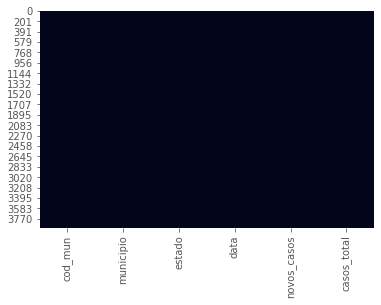

In [7]:
#gráfico heatmap para identificação do padrão de distribuição dos valores nulos no Data Frame
sns.heatmap(df_covid_19_br.isnull(), cbar=False); 

In [8]:
df_covid_19_br.isnull().sum()

cod_mun        0
municipio      0
estado         0
data           0
novos_casos    0
casos_total    0
dtype: int64

In [11]:
dic_data_inicial = {}
cod_municipios = df_covid_19_br[~filter_len_cod_mun].cod_mun.unique()
for codigo in cod_municipios:
    data_inicial = df_covid_19_br[df_covid_19_br.cod_mun == codigo]['data'].min()
    dic_data_inicial[codigo] = data_inicial

In [12]:
df_data_primeiro_caso = pd.DataFrame(data=dic_data_inicial.values(), index=dic_data_inicial.keys(), columns = ['data_primeiro_caso'])

In [13]:
df_data_primeiro_caso

,data_primeiro_caso
3550308,2020-02-25
3300407,2020-03-05
3205200,2020-03-05
2910800,2020-03-06
3304557,2020-03-07
...,...
3200102,2020-04-01
3200607,2020-04-01
2100055,2020-04-01
2304285,2020-04-01


### Geração do Shapefile com os dados de CoronaVirus

In [14]:
def preparing_shape_data(df):
    
    
    # retira os casos do estado que não estão associados a municipios
    filter_len_cod_mun = df.cod_mun.astype('str').str.len() == 2 #filtro de cod_mun de apenas dois caracteres
    df = df[~filter_len_cod_mun] # Retira do Data Frame df as linhas em que cod_mun tem apenas dois caracteres 
    
    # pivoteia o df, com cod_mun na linha, datas nas colunas e casos totais como valores
    df = df[['cod_mun',
              'data',
              'casos_total']].pivot_table(index='cod_mun', columns='data', values='casos_total')
    
    # corrige o nome das colunas
    list_new_column_names = []
    for old_name in df.columns:
        new_name = 'dia' + old_name.split('-')[2]+ old_name.split('-')[1]
        list_new_column_names.append(new_name)
    df.columns = list_new_column_names
    
    
    
    #list_new_column_names = []
    #for old_column_name in df.columns:
    #    new_name = 'dia' + old_column_name.split('-')[1] + old_column_name.split('-')[0]
    #    list_new_column_names.append(new_name)
    #df.columns = list_new_column_names
    
    # insere 0 nos casos em que o valores são nulos
    df.fillna(0, inplace=True)
    
    # transforma os dados em integers
    
    df = df.astype('int32')
    
    
    return df

In [15]:
# Gera o Data Frame com os dados de COVID no formato adequado para importação em Geo Data Frame
df_covid_19_br_to_shape = preparing_shape_data(df_covid_19_br)

In [16]:
# visualização do Data Frame com os dados para importação em Geo Data Frame
df_covid_19_br_to_shape

,dia2502,dia2902,dia0403,dia0503,dia0603,dia0703,dia0803,dia0903,dia1003,dia1103,...,dia2303,dia2403,dia2503,dia2603,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1100122,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100205,0,0,0,0,0,0,0,0,0,0,...,2,4,4,5,5,5,5,6,7,7
1200013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,7,7,8
1200401,0,0,0,0,0,0,0,0,0,0,...,17,21,23,24,25,25,31,34,34,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218805,0,0,0,0,0,0,0,0,0,0,...,5,5,6,6,6,7,7,7,7,7
5220603,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
5221403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
# Cria o Geo Data Frame com base na shapefile de todos os municipios do Brasil
gdf_municipios_br = gpd.read_file('BRMUE250GC_SIR.shp', encoding='utf-8')
gdf_municipios_br

,NM_MUNICIP,CD_GEOCMU,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


In [25]:
# Verifica a estrutura do Geo Data Frame
gdf_municipios_br.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
NM_MUNICIP    5572 non-null object
CD_GEOCMU     5572 non-null object
geometry      5572 non-null geometry
dtypes: geometry(1), object(2)
memory usage: 130.7+ KB


In [26]:
# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

In [27]:
# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

In [28]:
# Expande o Data Frame df_covid_19_br_to_shape para que tenha os mesmos indexes encontrados no Geo Data Frame

df_covid_19_br_to_shape = df_covid_19_br_to_shape.reindex(gdf_municipios_br.cod_mun.values)

In [29]:
# Faz a junção entre Geo Data Frame e o Data Frame 

gdf_municipios_br = gdf_municipios_br.merge(df_covid_19_br_to_shape, on='cod_mun')

In [30]:
gdf_municipios_br.iloc[:, 3:] = gdf_municipios_br.iloc[:, 3:].fillna(0)

In [31]:
gdf_municipios_br.nlargest(n=10, columns='dia3003')

,municipio,cod_mun,geometry,dia2502,dia2902,dia0403,dia0503,dia0603,dia0703,dia0803,...,dia2303,dia2403,dia2503,dia2603,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104
2537,SÃO PAULO,3550308,"POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...",1.00,2.00,3.00,6.00,10.00,13.00,15.00,...,687.00,718.00,733.00,902.00,1044.00,1044.00,1044.00,1233.00,1885.00,2418.00
1067,RIO DE JANEIRO,3304557,"MULTIPOLYGON (((-43.70288 -22.98523, -43.70286...",0.00,0.00,0.00,0.00,0.00,1.00,2.00,...,212.00,276.00,332.00,369.00,431.00,489.00,516.00,553.00,586.00,697.00
440,FORTALEZA,2304400,"POLYGON ((-38.56771 -3.84953, -38.57672 -3.845...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,153.00,172.00,198.00,225.00,268.00,304.00,338.00,353.00,371.00,413.00
2557,BRASÍLIA,5300108,"POLYGON ((-47.81455 -16.04995, -47.81478 -16.0...",0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,146.00,177.00,195.00,203.00,242.00,260.00,298.00,312.00,333.00,355.00
3566,BELO HORIZONTE,3106200,"POLYGON ((-43.92060 -19.80202, -43.92021 -19.8...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,87.00,89.00,92.00,96.00,123.00,132.00,146.00,163.00,163.00,188.00
1072,PORTO ALEGRE,4314902,"MULTIPOLYGON (((-51.28678 -30.12193, -51.28710...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,41.00,48.00,88.00,103.00,107.00,107.00,143.00,143.00,190.00,190.00
2346,MANAUS,1302603,"POLYGON ((-59.92021 -2.61052, -59.91470 -2.616...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,31.00,45.00,52.00,63.00,75.00,105.00,131.00,140.00,159.00,179.00
3087,SALVADOR,2927408,"POLYGON ((-38.39181 -12.84328, -38.39180 -12.8...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,37.00,48.00,57.00,67.00,78.00,81.00,103.00,117.00,132.00,153.00
4876,CURITIBA,4106902,"POLYGON ((-49.24591 -25.34942, -49.24536 -25.3...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,34.00,40.00,60.00,66.00,71.00,73.00,73.00,76.00,87.00,98.00
1713,RECIFE,2611606,"POLYGON ((-34.91029 -7.95375, -34.91285 -7.969...",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,30.00,30.00,33.00,33.00,41.00,46.00,49.00,53.00,58.00,65.00


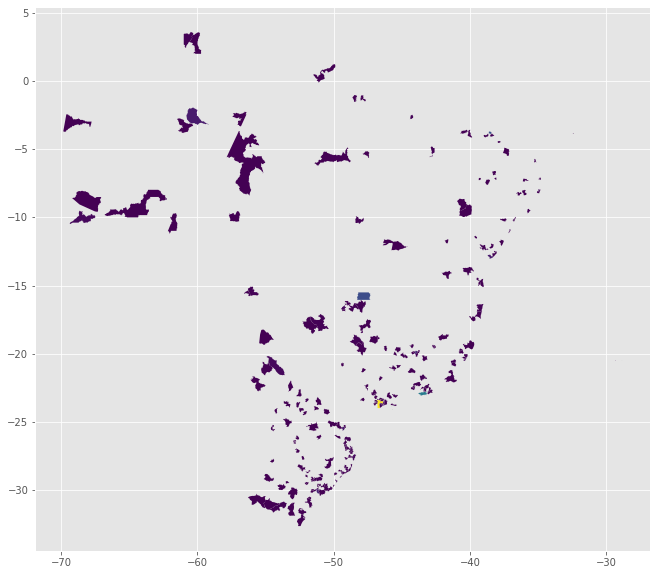

In [32]:
gdf_municipios_br[gdf_municipios_br['dia2703'] != 0].plot(column='dia2703', figsize=(15, 10))

In [33]:
gdf_municipios_br.to_file(driver = 'ESRI Shapefile', filename = 'BRMUE250GC_SIR_alterado.shp')

In [34]:
df_fatores_geograficos = pd.read_csv('base_compilada_de_fatores_geograficos.csv', delimiter=';', encoding='utf-8')

In [35]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 12 columns):
cod_mun                5570 non-null int64
UF                     5570 non-null object
Município              5570 non-null object
pop2019                5570 non-null int64
pib2017milreais        5570 non-null int64
export_fob_2019        5570 non-null int64
import_fob_2019        5570 non-null int64
pip_per_capita17       5570 non-null int64
hierarquia_urbana07    5570 non-null object
hierarquia             5570 non-null int64
voos_dom               5570 non-null int64
voos_int               5570 non-null int64
dtypes: int64(9), object(3)
memory usage: 522.3+ KB


In [36]:
df_fatores_geograficos.describe()

,cod_mun,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,voos_dom,voos_int
count,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00,5570.00
mean,3253590.77,37728.39,1181924.41,40408377.94,31839822.75,2199.07,1.27,12.08,1.00
std,984910.34,221458.06,11621728.62,309921003.98,312262568.40,2094.63,1.05,254.33,40.66
min,1100015.00,781.00,12993.00,0.00,0.00,329.00,0.00,0.00,0.00
25%,2512125.75,5446.50,79101.50,0.00,0.00,949.00,1.00,0.00,0.00
50%,3146280.00,11631.00,176621.50,0.00,0.00,1660.00,1.00,0.00,0.00
75%,4119189.50,25490.50,470221.25,1264063.75,164892.25,2705.00,1.00,0.00,0.00
max,5300108.00,12252023.00,699288352.00,11309835507.00,10129708024.00,34485.00,11.00,15172.00,2791.00


In [37]:
df_fatores_geograficos.set_index('cod_mun', inplace=True)

In [38]:
df_fatores_geograficos = df_fatores_geograficos.join(df_covid_19_br_to_shape, on='cod_mun')

In [39]:
df_fatores_geograficos.iloc[:, 10:] = df_fatores_geograficos.iloc[:, 10:].fillna(0)

In [40]:
df_fatores_geograficos = df_fatores_geograficos.join(df_data_primeiro_caso, on='cod_mun')

In [41]:
df_fatores_geograficos.data_primeiro_caso = pd.to_datetime(df_fatores_geograficos.data_primeiro_caso)

In [42]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 1100015 to 5300108
Data columns (total 43 columns):
UF                     5570 non-null object
Município              5570 non-null object
pop2019                5570 non-null int64
pib2017milreais        5570 non-null int64
export_fob_2019        5570 non-null int64
import_fob_2019        5570 non-null int64
pip_per_capita17       5570 non-null int64
hierarquia_urbana07    5570 non-null object
hierarquia             5570 non-null int64
voos_dom               5570 non-null int64
voos_int               5570 non-null int64
dia2502                5570 non-null float64
dia2902                5570 non-null float64
dia0403                5570 non-null float64
dia0503                5570 non-null float64
dia0603                5570 non-null float64
dia0703                5570 non-null float64
dia0803                5570 non-null float64
dia0903                5570 non-null float64
dia1003                5570 non-null float64
dia

In [36]:
df_fatores_geograficos['data_padrao'] = pd.to_datetime('2020-02-24')

df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['data_primeiro_caso'].sub(df_fatores_geograficos['data_padrao'], axis=0)


df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['dias_contaminação_referencia'] / np.timedelta64(1, 'D')


In [37]:
df_fatores_geograficos

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,dia2502,...,dia2603,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104,data_primeiro_caso,data_padrao,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,1961,Centro Local,1.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
1100023,RO,Ariquemes,107863,2296074,38002769,738809,2139,Centro Subregional B,4.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
1100031,RO,Cabixi,5312,138894,137660,0,2232,Centro Local,1.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
1100049,RO,Cacoal,85359,2127523,20514957,53854,2404,Centro Subregional B,4.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
1100056,RO,Cerejeiras,16323,448524,97838806,59259,2501,Centro de Zona B,2.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,Vianópolis,13863,395787,0,0,2894,Centro Local,1.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
5222054,GO,Vicentinópolis,8743,350765,6518444,0,4177,Centro Local,1.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan
5222203,GO,Vila Boa,6171,137500,0,0,2399,Centro Local,1.00,nan,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaT,2020-02-24,nan


In [38]:
df_fatores_geograficos.columns

Index(['UF', 'Município', 'pop2019', 'pib2017milreais', 'export_fob_2019',
       'import_fob_2019', 'pip_per_capita17', 'hierarquia_urbana07',
       'hierarquia', 'dia2502', 'dia2902', 'dia0403', 'dia0503', 'dia0603',
       'dia0703', 'dia0803', 'dia0903', 'dia1003', 'dia1103', 'dia1203',
       'dia1303', 'dia1403', 'dia1503', 'dia1603', 'dia1703', 'dia1803',
       'dia1903', 'dia2003', 'dia2103', 'dia2203', 'dia2303', 'dia2403',
       'dia2503', 'dia2603', 'dia2703', 'dia2803', 'dia2903', 'dia3003',
       'dia3103', 'dia0104', 'data_primeiro_caso', 'data_padrao',
       'dias_contaminação_referencia'],
      dtype='object')

In [39]:
corr = df_fatores_geograficos[['pop2019', 
                        'pib2017milreais', 
                        'export_fob_2019',
                        'import_fob_2019',
                        'pip_per_capita17',
                        'hierarquia',
                        'dia2502',
                        'dias_contaminação_referencia']].corr()

In [40]:
corr

,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,dia2502,dias_contaminação_referencia
pop2019,1.00,0.96,0.46,0.69,0.08,0.47,0.77,-0.45
pib2017milreais,0.96,1.00,0.46,0.69,0.13,0.37,0.82,-0.40
export_fob_2019,0.46,0.46,1.00,0.59,0.23,0.33,0.19,-0.20
import_fob_2019,0.69,0.69,0.59,1.00,0.22,0.35,0.45,-0.30
pip_per_capita17,0.08,0.13,0.23,0.22,1.00,0.13,0.03,-0.06
hierarquia,0.47,0.37,0.33,0.35,0.13,1.00,0.17,-0.56
dia2502,0.77,0.82,0.19,0.45,0.03,0.17,1.00,-0.23
dias_contaminação_referencia,-0.45,-0.40,-0.20,-0.30,-0.06,-0.56,-0.23,1.00


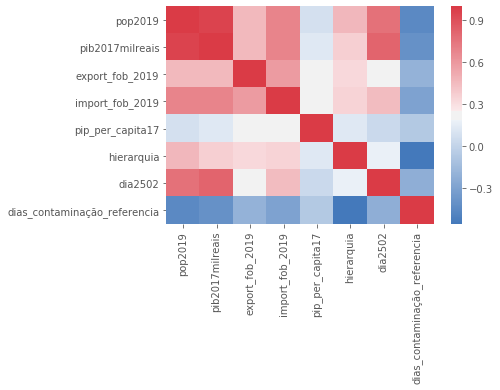

In [41]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

**arranjos populacionais**

In [43]:
df_arranjos_populacionais = pd.read_csv('arranjo_populacional.csv', sep=';', decimal=',')

In [44]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_interna'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_interna'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum();

C:\Users\Acer A315\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_geral'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_geral'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'pessoas_em_pendularidade_trabalho'].sum() / df_arranjos_populacionais.loc[:,'pessoas_em_pendularidade_trabalho'].sum();

In [50]:
df_fatores_geograficos = df_fatores_geograficos.join(df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']], on='cod_mun')

In [52]:
df_fatores_geograficos.to_csv('fatores_total.csv', sep=';', decimal=',', encoding='utf-16')

In [48]:
df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']]

,cod_mun,peso_integracao_interna,peso_integracao_geral
0,3500105,0.51,0.00
1,3520806,0.06,0.00
2,3527405,0.32,0.00
3,3528908,0.06,0.00
4,3540853,0.06,0.00
...,...,...,...
948,3306305,0.57,0.00
949,3501202,0.04,0.00
950,3536257,0.02,0.00
951,3551306,0.03,0.00


In [218]:
df_arranjos_populacionais.loc[:,'peso_integracao_geral'].sum()

18.511799964153074

In [128]:
next(iter_test)[1].values[0]

'Alvorada do Norte - Simolândia/GO'

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == next(iter_test)[1].values[0]
df_arranjos_populacionais[filtro_arranjo_pop]

In [166]:
df_arranjos_populacionais['peso'] = 0

In [194]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'São José do Rio Preto/SP'
df_arranjos_populacionais.loc[:,'peso'].sum()

294.0

In [172]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'Antônio Prado/RS'

#df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'peso'] = 

df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum()


#df_arranjos_populacionais[filtro_arranjo_pop]['p'] = df_arranjos_populacionais[filtro_arranjo_pop].pop_2019.sum()

26   0.66
27   0.34
Name: pop_2019, dtype: float64

In [133]:
df_arranjos_populacionais[filtro_arranjo_pop]['peso']

,arranjo_populacional,municipios,uf,cod_mun,pop_sem_data,pop_2019,nucleo,pessoas_em_pendularidade_trabalho,indice_integracao,mancha_continua,desmembrado_de_mun_arranjo_1988,nivel,via,iteracao
19,Americana - Santa Bárbara d´Oeste/SP,Americana,SP,3501608,210.638,239.597,Sim,41.118,"0,27",Sim,Não,1,-,0
20,Americana - Santa Bárbara d´Oeste/SP,Nova Odessa,SP,3533403,51.242,60.174,Não,10.848,"0,29",Sim,Não,1,-,0
21,Americana - Santa Bárbara d´Oeste/SP,Santa Bárbara d´Oeste,SP,3545803,180.009,193.475,Sim,35.560,"0,27",Sim,Não,1,-,0


In [106]:
df_arranjos_populacionais.loc

,arranjo_populacional,municipios,uf,cod_mun,pop_sem_data,pop_2019,nucleo,pessoas_em_pendularidade_trabalho,indice_integracao,mancha_continua,desmembrado_de_mun_arranjo_1988,nivel,via,iteracao
0,Adamantina - Lucélia/SP,Adamantina,SP,3500105,33.797,35.068,Sim,2.268,"0,1",Sim,Não,1,-,0
1,Adamantina - Lucélia/SP,Inúbia Paulista,SP,3520806,3.630,3.991,Não,423,"0,17",Não,Não,1,-,1
2,Adamantina - Lucélia/SP,Lucélia,SP,3527405,19.882,21.747,Sim,2.289,"0,18",Sim,Não,1,-,0
3,Adamantina - Lucélia/SP,Mariápolis,SP,3528908,3.916,4.084,Não,499,"0,2",Não,Não,1,-,1
4,Adamantina - Lucélia/SP,Pracinha,SP,3540853,2.858,4.093,Não,261,"0,26",Não,Sim,1,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,Volta Redonda - Barra Mansa/RJ,Volta Redonda,RJ,3306305,257.803,273.012,Sim,24.057,"0,14",Sim,Não,1,-,0
949,Votuporanga/SP,Álvares Florence,SP,3501202,3.897,3.679,Não,609,"0,25",Não,Não,1,-,0
950,Votuporanga/SP,Parisi,SP,3536257,2.032,2.161,Não,464,"0,32",Não,Sim,1,-,0
951,Votuporanga/SP,Sebastianópolis do Sul,SP,3551306,3.031,3.513,Não,797,"0,38",Não,Não,1,-,0


Text(0.5, 1.0, 'First Plot')

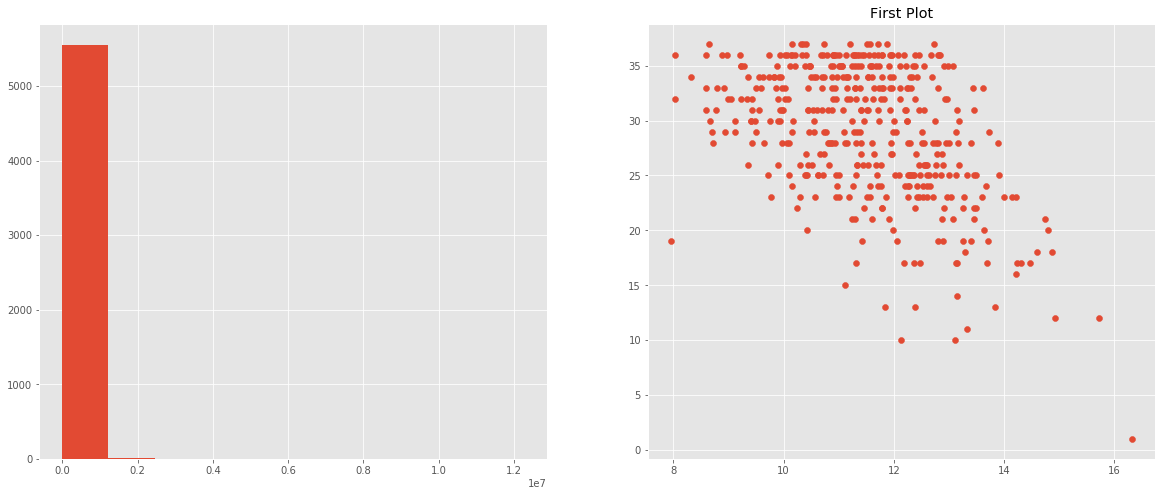

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=np.log(df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);
ax[1].set_title('First Plot')
ax[1].set_title('First Plot')

In [43]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

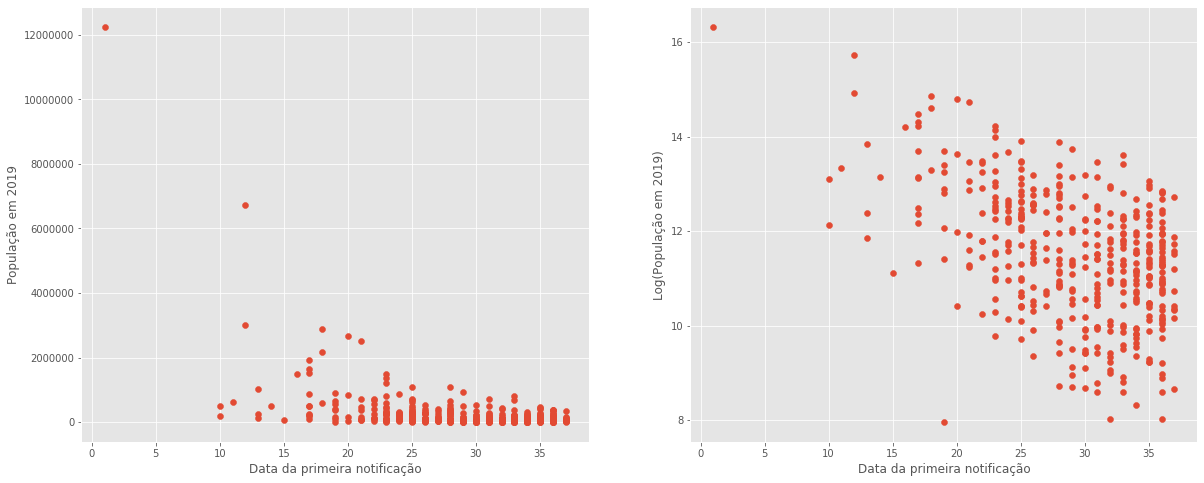

In [44]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

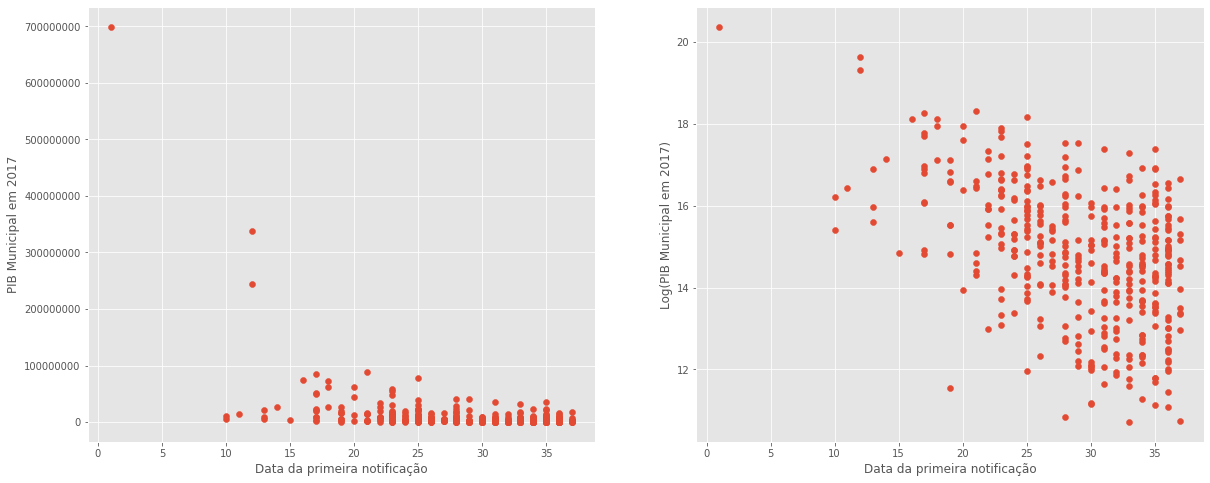

In [45]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pib2017milreais'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB Municipal em 2017 (R$1.000)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('PIB Municipal em 2017')


ax[1].scatter(y=np.log(df_fatores_geograficos['pib2017milreais'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB Municipal em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

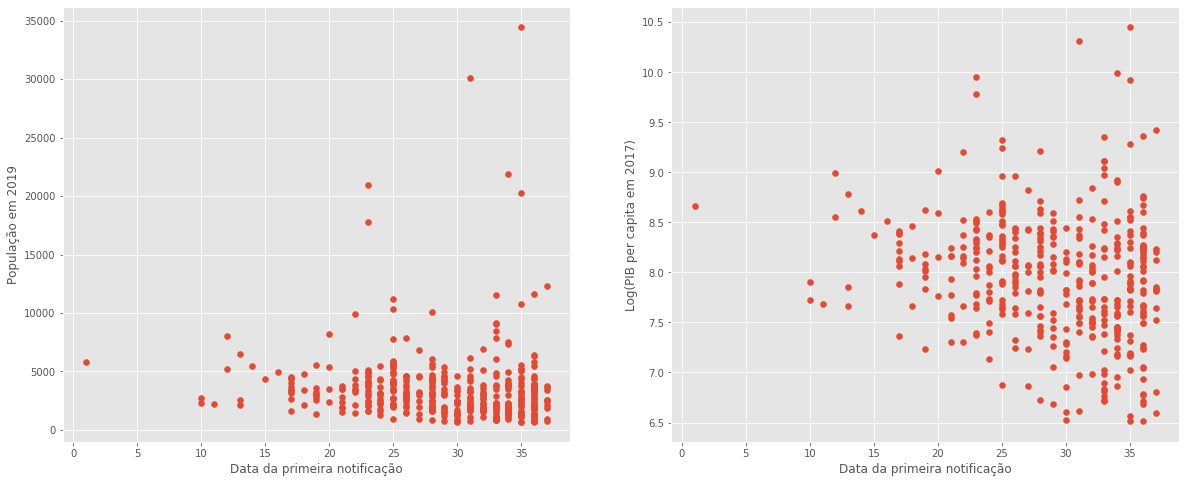

In [46]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pip_per_capita17'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB per capita em 2017(R$)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pip_per_capita17'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB per capita em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

C:\Users\Acer A315\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


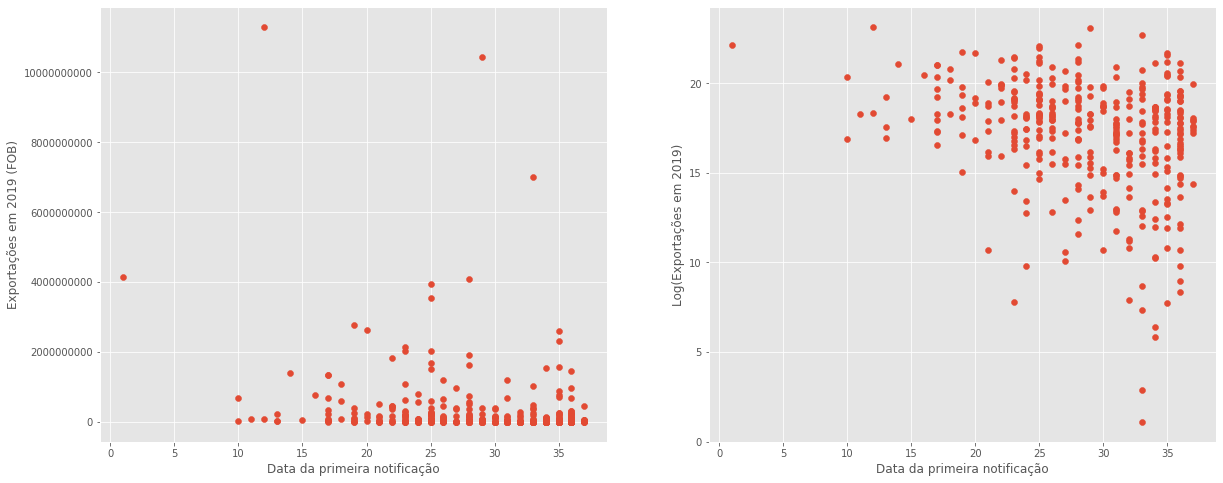

In [47]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['export_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Exportações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('Exportações em 2019 (FOB)')


ax[1].scatter(y=np.log(df_fatores_geograficos['export_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Exportações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

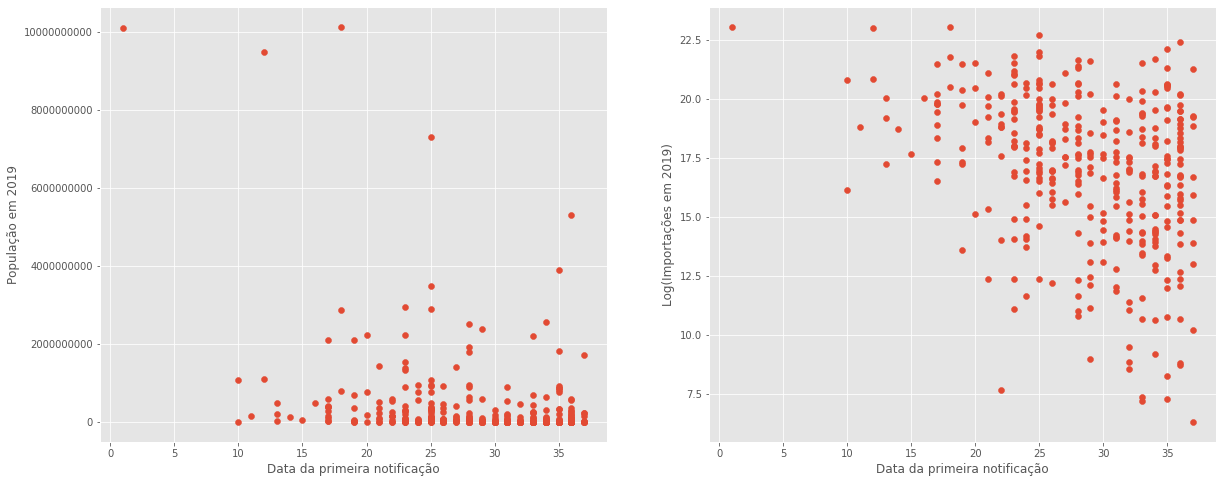

In [48]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['import_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Importações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['import_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Importações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [49]:
plt.scatter?

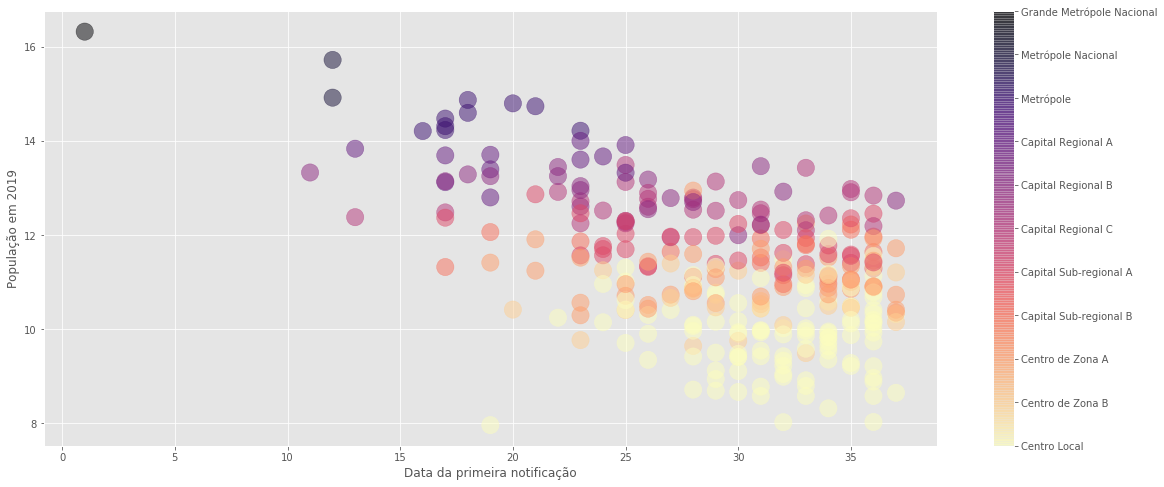

In [50]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.5,
            cmap=color_map,
            s=300);


teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Data da primeira notificação')
plt.ylabel('População em 2019');

In [51]:
plt.legend?

In [52]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

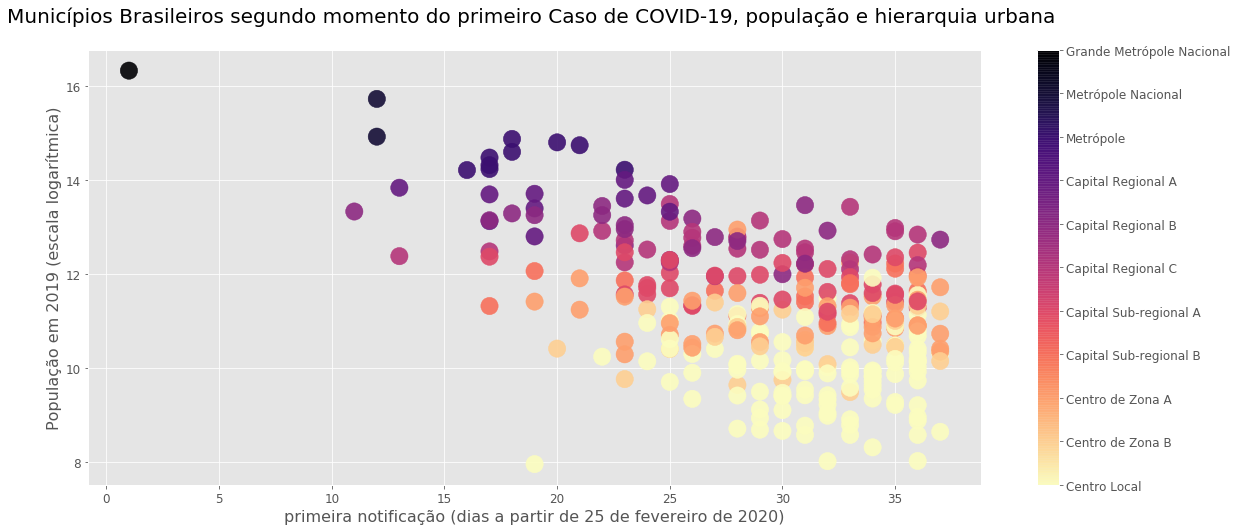

In [53]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

scatter = plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.9,
            cmap=color_map,
            s= 300);

ax.set_title('Municípios Brasileiros segundo momento do primeiro Caso de COVID-19, população e hierarquia urbana \n')
teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('primeira notificação (dias a partir de 25 de fevereiro de 2020)')
plt.ylabel('População em 2019 (escala logarítmica)');


plt.savefig('covid.png')
#lgnd = plt.legend(handles=handles, loc="lower left", scatterpoints=1)

#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
#lgnd.legendHandles[0]._sizes = [30]
#lgnd.legendHandles[1]._sizes = [30]

Para melhorar o gráfico acima, preciso pegar uns parâmetros nos links abaixo

https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html

https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D

https://matplotlib.org/3.1.0/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working

Minha intenção é colocar uma quarta variável (PIB) nesse mesmo gráfico

https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend

https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size

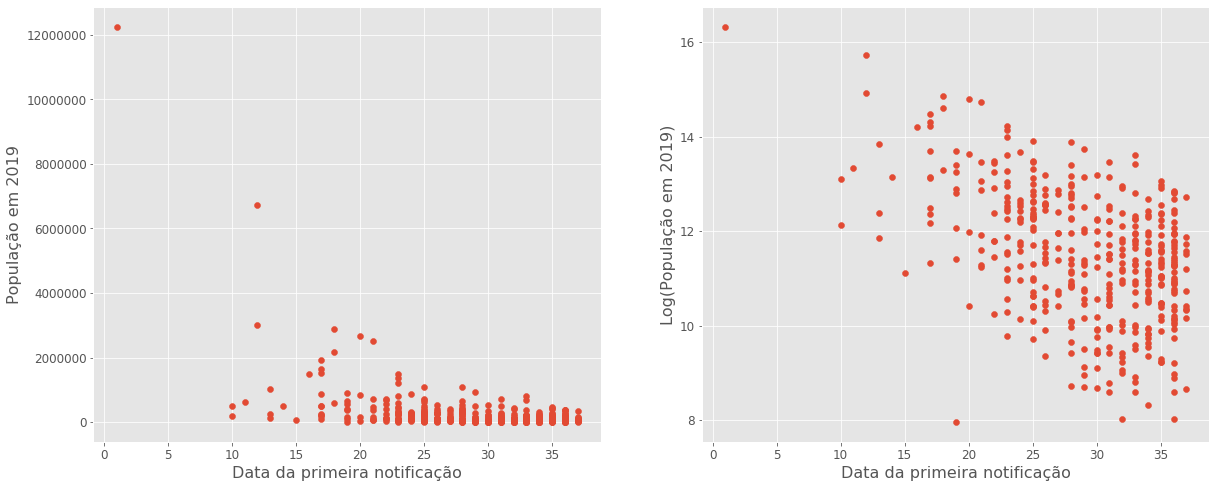

In [54]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002202D9D3400>,
      dtype=object)

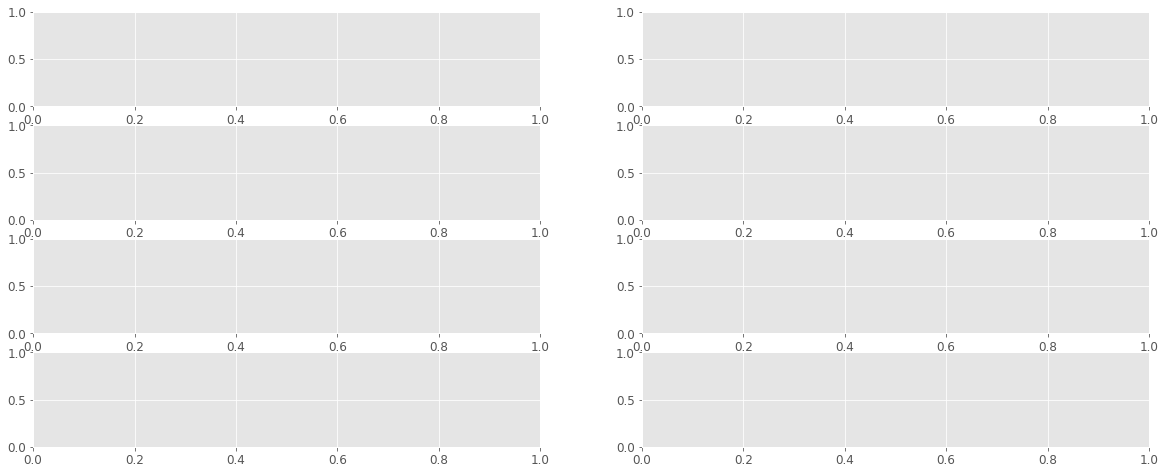

In [55]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax

NameError: name 'variavel' is not defined

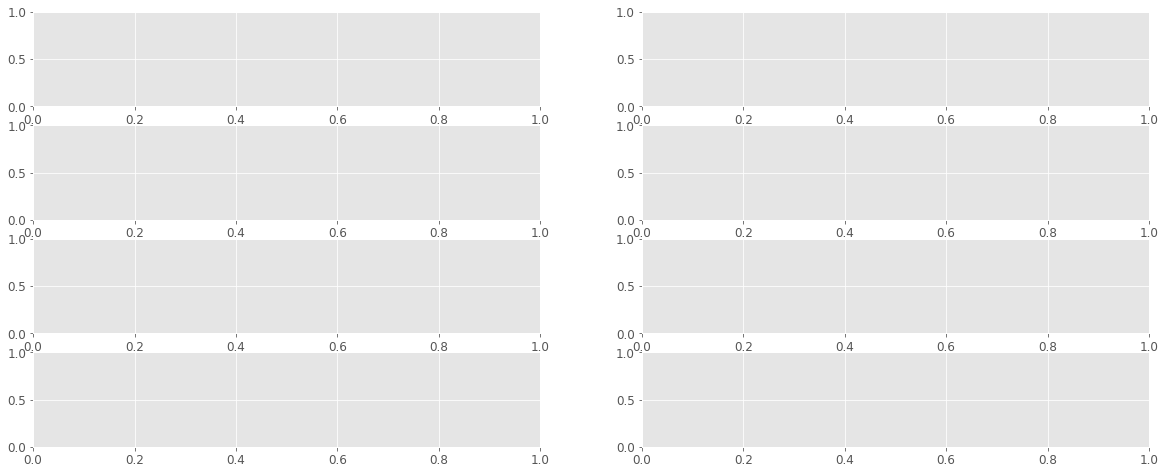

In [56]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax[0,0].scatter(x=np.log(df_fatores_geograficos[variavel][df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

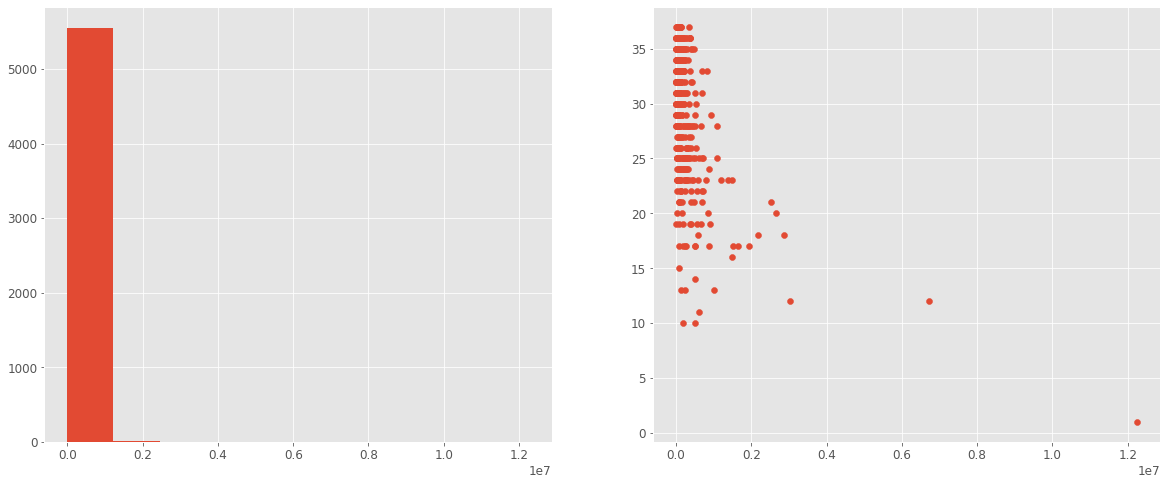

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()], y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [58]:
df_fatores_geograficos.pop2019

cod_mun
1100015      22945
1100023     107863
1100031       5312
1100049      85359
1100056      16323
            ...   
5222005      13863
5222054       8743
5222203       6171
5222302       5821
5300108    3015268
Name: pop2019, Length: 5570, dtype: int64

In [59]:
df_fatores_geograficos.dia3103.max()

1885.0

In [60]:
df_fatores_geograficos.columns

Index(['UF', 'Município', 'pop2019', 'pib2017milreais', 'export_fob_2019',
       'import_fob_2019', 'pip_per_capita17', 'hierarquia_urbana07',
       'hierarquia', 'dia2502', 'dia2902', 'dia0403', 'dia0503', 'dia0603',
       'dia0703', 'dia0803', 'dia0903', 'dia1003', 'dia1103', 'dia1203',
       'dia1303', 'dia1403', 'dia1503', 'dia1603', 'dia1703', 'dia1803',
       'dia1903', 'dia2003', 'dia2103', 'dia2203', 'dia2303', 'dia2403',
       'dia2503', 'dia2603', 'dia2703', 'dia2803', 'dia2903', 'dia3003',
       'dia3103', 'dia0104', 'data_primeiro_caso', 'data_padrao',
       'dias_contaminação_referencia'],
      dtype='object')

In [61]:
list_colunas_selecionadas = list(df_fatores_geograficos.columns[2:10])
list_colunas_selecionadas.append(df_fatores_geograficos.columns[-3])

In [62]:
list_colunas_selecionadas

['pop2019',
 'pib2017milreais',
 'export_fob_2019',
 'import_fob_2019',
 'pip_per_capita17',
 'hierarquia_urbana07',
 'hierarquia',
 'dia2502',
 'data_primeiro_caso']

In [63]:
df_fatores_geograficos_correlacao =  df_fatores_geograficos.loc[:, list_colunas_selecionadas]
df_fatores_geograficos_correlacao

,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,dia2502,data_primeiro_caso
cod_mun,,,,,,,,,
1100015,22945,498864,198695,13294,1961,Centro Local,1.00,nan,NaT
1100023,107863,2296074,38002769,738809,2139,Centro Subregional B,4.00,nan,NaT
1100031,5312,138894,137660,0,2232,Centro Local,1.00,nan,NaT
1100049,85359,2127523,20514957,53854,2404,Centro Subregional B,4.00,nan,NaT
1100056,16323,448524,97838806,59259,2501,Centro de Zona B,2.00,nan,NaT
...,...,...,...,...,...,...,...,...,...
5222005,13863,395787,0,0,2894,Centro Local,1.00,nan,NaT
5222054,8743,350765,6518444,0,4177,Centro Local,1.00,nan,NaT
5222203,6171,137500,0,0,2399,Centro Local,1.00,nan,NaT


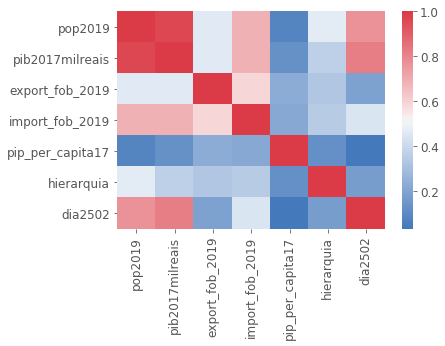

In [64]:
corr = df_fatores_geograficos_correlacao.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [65]:
df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0]

,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,dia2502,data_primeiro_caso
cod_mun,,,,,,,,,
1100015,22945,498864,198695,13294,1961,Centro Local,1.00,nan,NaT
1100023,107863,2296074,38002769,738809,2139,Centro Subregional B,4.00,nan,NaT
1100031,5312,138894,137660,0,2232,Centro Local,1.00,nan,NaT
1100049,85359,2127523,20514957,53854,2404,Centro Subregional B,4.00,nan,NaT
1100056,16323,448524,97838806,59259,2501,Centro de Zona B,2.00,nan,NaT
...,...,...,...,...,...,...,...,...,...
5222005,13863,395787,0,0,2894,Centro Local,1.00,nan,NaT
5222054,8743,350765,6518444,0,4177,Centro Local,1.00,nan,NaT
5222203,6171,137500,0,0,2399,Centro Local,1.00,nan,NaT


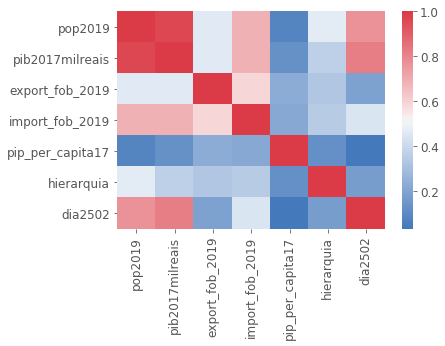

In [66]:
corr = df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

C:\Users\Acer A315\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Acer A315\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


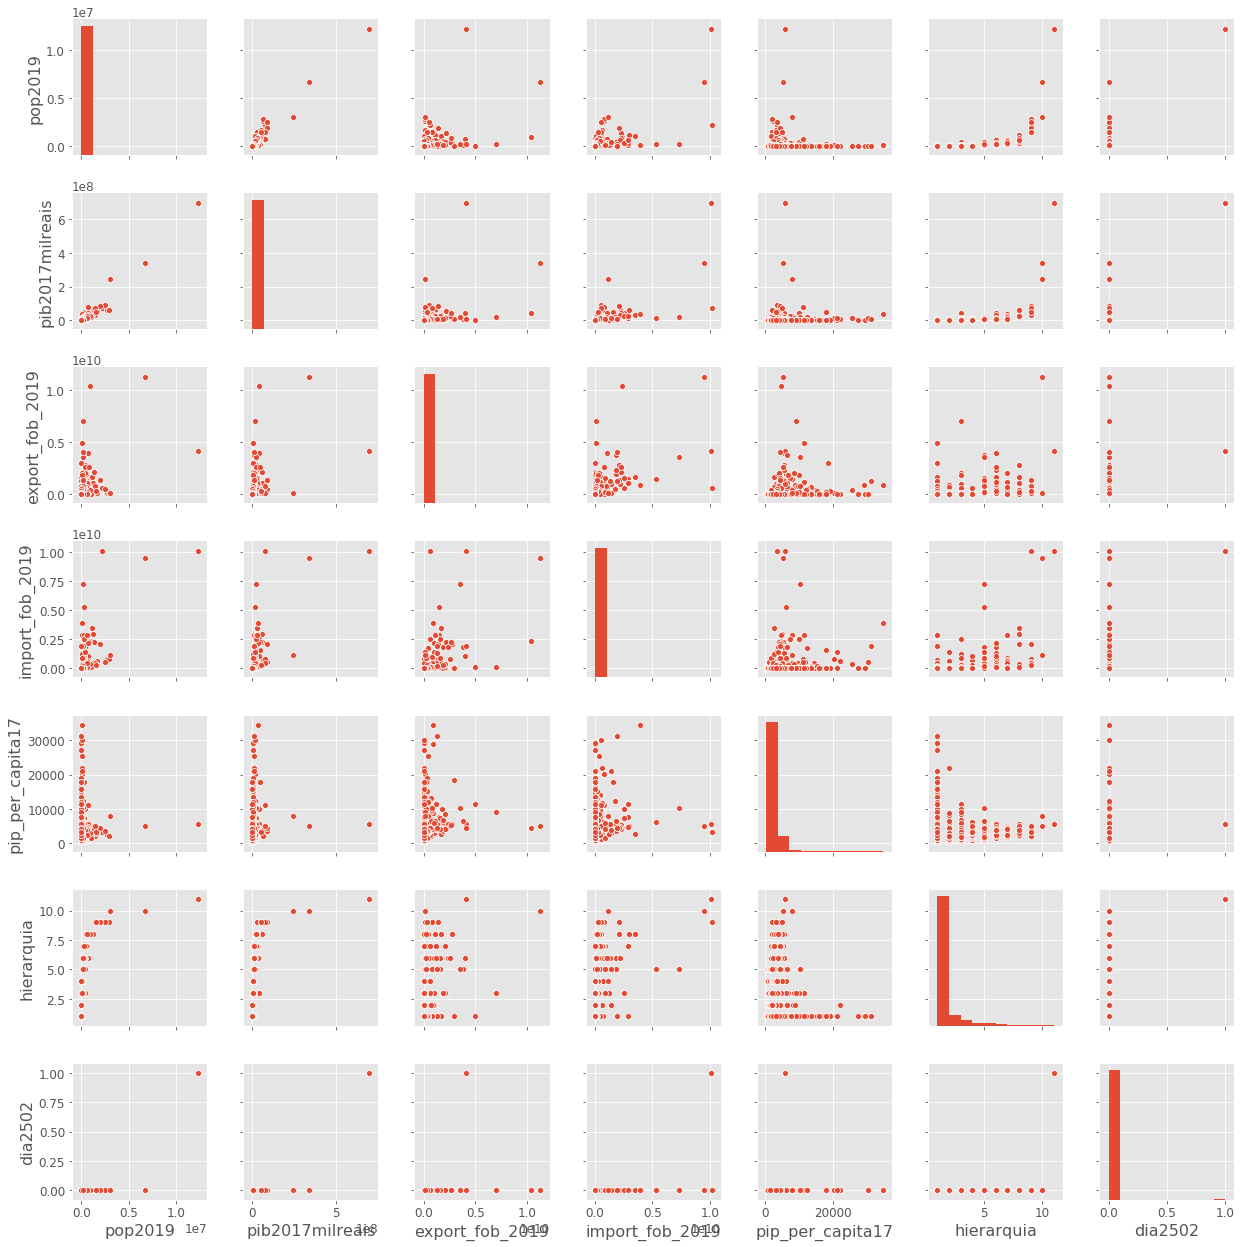

In [67]:
sns.pairplot(df_fatores_geograficos_correlacao)

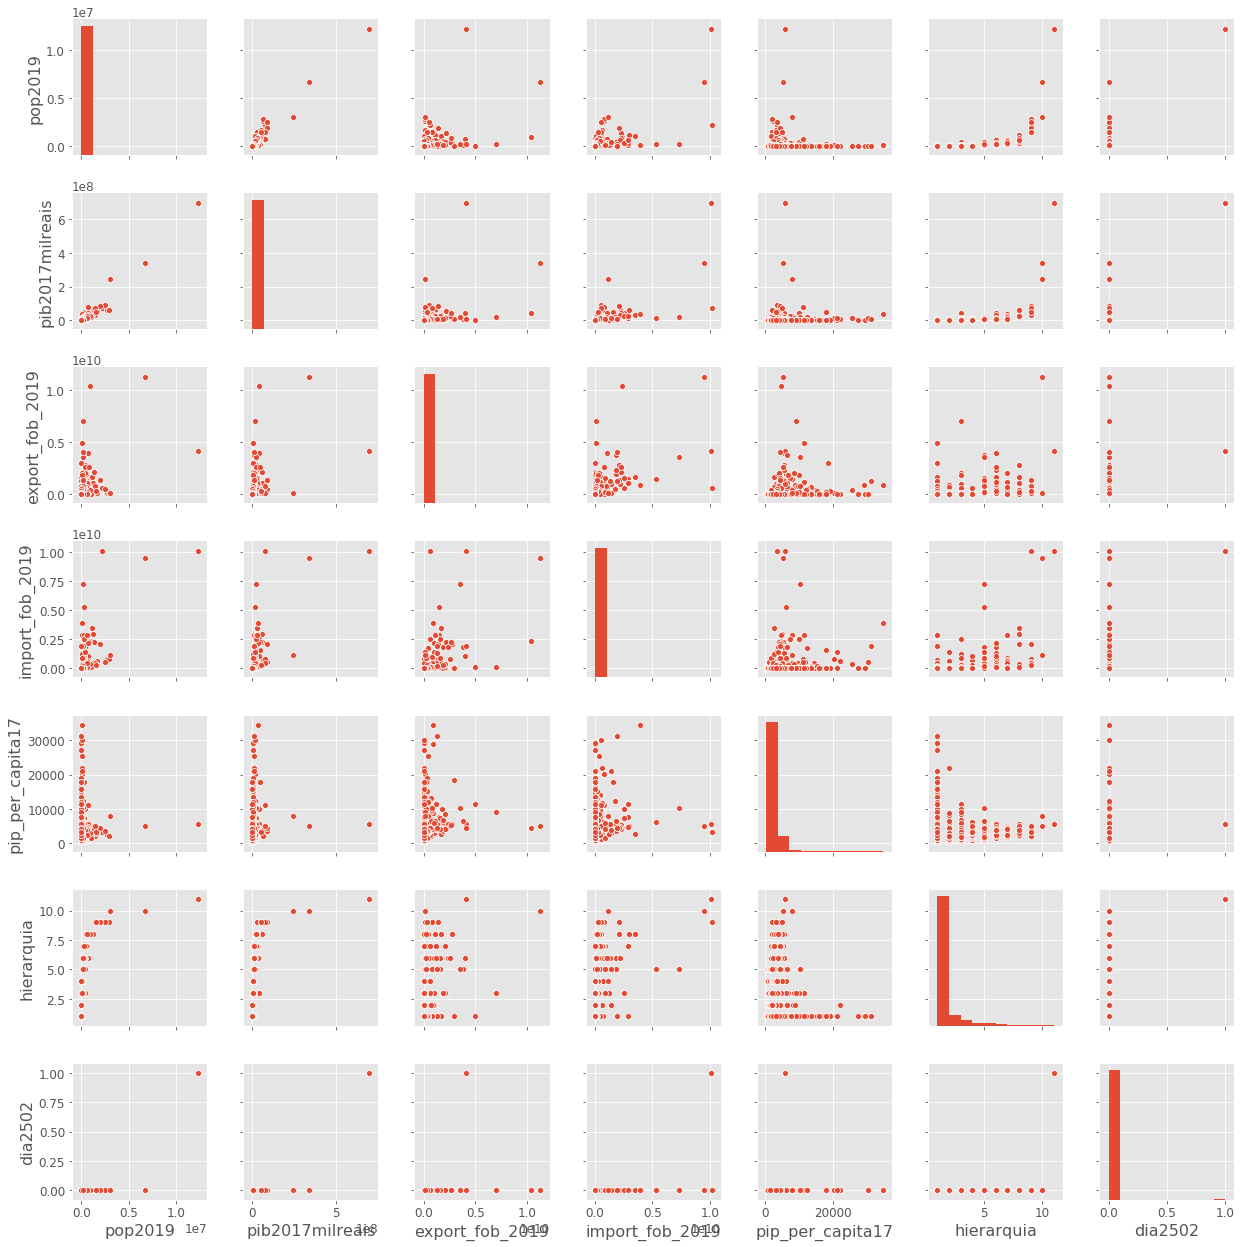

In [68]:
sns.pairplot(df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0])

In [69]:
corr

,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,dia2502
pop2019,1.00,0.96,0.46,0.69,0.08,0.47,0.77
pib2017milreais,0.96,1.00,0.46,0.69,0.13,0.37,0.82
export_fob_2019,0.46,0.46,1.00,0.59,0.23,0.33,0.19
import_fob_2019,0.69,0.69,0.59,1.00,0.22,0.35,0.45
pip_per_capita17,0.08,0.13,0.23,0.22,1.00,0.13,0.03
hierarquia,0.47,0.37,0.33,0.35,0.13,1.00,0.17
dia2502,0.77,0.82,0.19,0.45,0.03,0.17,1.00


In [70]:
df_fatores_geograficos['dia3103'].sum()

5748.0

In [71]:
df_fatores_geograficos_semzeros = df_fatores_geograficos[df_fatores_geograficos.iloc[:,-1] != 0]

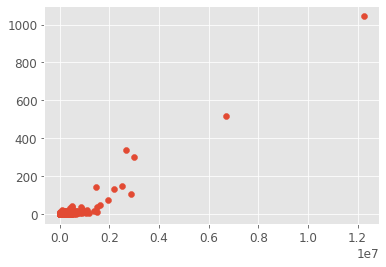

In [72]:
plt.scatter(df_fatores_geograficos['pop2019'], df_fatores_geograficos['dia2903'])

In [73]:
plt.scatter(df_fatores_geograficos_correlacao_semzeros['pop2019'], df_fatores_geograficos_correlacao_semzeros['dia2903'])

NameError: name 'df_fatores_geograficos_correlacao_semzeros' is not defined

In [74]:
plt.scatter(df_fatores_geograficos_correlacao['pop2019'], df_fatores_geograficos_correlacao['dia2903'])

KeyError: 'dia2903'

In [75]:
plt.scatter(df_fatores_geograficos_correlacao['export_fob_2019'], df_fatores_geograficos_correlacao['dia2903'])

KeyError: 'dia2903'

In [76]:
sns.pairplot(df_fatores_geograficos_correlacao[['pop2019', 'dia2903']][df_fatores_geograficos_correlacao.iloc[:,-1] != 0], size=5)

KeyError: "['dia2903'] not in index"

In [101]:
df_arranjos_populacionais

,arranjo_populacional,municipios,uf,cod_mun,pop_sem_data,nucleo,pessoas_em_pendularidade_trabalho,indice_integracao,mancha_continua,desmembrado_de_mun_arranjo_1988,nivel,via,iteracao
0,Adamantina - Lucélia/SP,Adamantina,SP,3500105,33.797,Sim,2.268,"0,1",Sim,Não,1,-,0
1,Adamantina - Lucélia/SP,Inúbia Paulista,SP,3520806,3.630,Não,423,"0,17",Não,Não,1,-,1
2,Adamantina - Lucélia/SP,Lucélia,SP,3527405,19.882,Sim,2.289,"0,18",Sim,Não,1,-,0
3,Adamantina - Lucélia/SP,Mariápolis,SP,3528908,3.916,Não,499,"0,2",Não,Não,1,-,1
4,Adamantina - Lucélia/SP,Pracinha,SP,3540853,2.858,Não,261,"0,26",Não,Sim,1,-,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,Volta Redonda - Barra Mansa/RJ,Volta Redonda,RJ,3306305,257.803,Sim,24.057,"0,14",Sim,Não,1,-,0
949,Votuporanga/SP,Álvares Florence,SP,3501202,3.897,Não,609,"0,25",Não,Não,1,-,0
950,Votuporanga/SP,Parisi,SP,3536257,2.032,Não,464,"0,32",Não,Sim,1,-,0
951,Votuporanga/SP,Sebastianópolis do Sul,SP,3551306,3.031,Não,797,"0,38",Não,Não,1,-,0
